In [3]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import shutil
from tqdm import tqdm
os.getcwd()
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.2.0


In [4]:
#Ref: https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np
import keras 
from keras.layers import *
from keras.models import *

traindf=pd.read_csv('train.csv',dtype=str)
testdf=pd.read_csv('test.csv',dtype=str)

traindf['age']=traindf.age.astype('int64')
#traindf['gender']=traindf.gender.astype('int64')

testdf['age']=traindf.age.astype('int64')
#testdf['gender']=traindf.gender.astype('int64')


print(traindf.head())
print(testdf.head())

print(traindf.info())
print(testdf.info())


                                           full_path gender  age
0  data/imdb/50/nm0004950_rm4036071168_1972-4-17_...      0   38
1  data/imdb/77/nm0004977_rm474265344_1973-7-15_2...      1   37
2  data/imdb/21/nm0019221_rm3640760320_1948-9-11_...      1   16
3  data/imdb/34/nm1289434_rm2872508160_1983-2-23_...      0   32
4  data/imdb/90/nm0001590_rm687003392_1952-5-15_2...      1   57
                                           full_path gender  age
0  data/imdb/44/nm0089244_rm238668800_1939-8-7_19...      0   38
1          data/wiki/21/32518421_1991-09-01_2015.jpg      1   37
2          data/wiki/76/38687576_1939-08-29_1961.jpg      1   16
3  data/imdb/88/nm0005388_rm594123264_1970-5-15_2...      1   32
4  data/imdb/25/nm0001325_rm2254805248_1959-11-3_...      1   57
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156918 entries, 0 to 156917
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   full_path  156918 non-nul

In [5]:
#train and validation data generators

img_dim=128

##Include data augmentation::
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

train_generator=datagen.flow_from_dataframe(dataframe=traindf,
directory=None,
x_col='full_path',
y_col=['age','gender'],
subset="training",
#try a smaller batch size                                            
batch_size=32,
seed=42,
shuffle=True,
class_mode='multi_output', 
target_size=(img_dim,img_dim))

valid_generator=datagen.flow_from_dataframe(
dataframe=traindf,
directory=None,
x_col='full_path',
y_col=['age','gender'],
subset="validation",
batch_size=32, #***Set this to some number that divides your total number of images in your test set exactly
seed=42,
shuffle=True,
class_mode='multi_output',
target_size=(img_dim,img_dim))

Found 117689 validated image filenames.
Found 39229 validated image filenames.


In [6]:
#test data generator

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=testdf,
directory=None,
x_col='full_path',
y_col=None,
batch_size=1, #***Set this to some number that divides your total number of images in your test set exactly
seed=42,
shuffle=False,
class_mode=None,
target_size=(img_dim,img_dim))

Found 52566 validated image filenames.


In [7]:
#Define model

inputs = Input(shape = (img_dim,img_dim, 3))

# Begin
model = Conv2D(filters=128, kernel_size=(3, 3), padding='same', strides= 2, activation='relu', input_shape=(img_dim, img_dim, 3))(inputs)
model = MaxPool2D(pool_size=(3, 3), strides= 2)(model)
model = BatchNormalization(momentum=0.15)(model)

model = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)

model = Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu')(model)
model = GlobalAveragePooling2D()(model)

age_model = Dense(16, activation='relu')(model)
age_model= Dropout(0.4)(age_model)
age_model = Dense(1, activation='relu',name='age')(age_model)

gender_model = Dense(16, activation='relu')(model)
gender_model = Dropout(0.4)(gender_model)
gender_model = Dense(1, activation='softmax',name='gender')(gender_model)

In [8]:
model = Model(inputs=inputs, outputs=[age_model,gender_model])
model.compile(optimizer = tf.keras.optimizers.Adam(0.002), 
              loss ={'age':'mse','gender':'binary_crossentropy'},metrics={'age':'mae',"gender":"accuracy"})
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 128)  3584        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 31, 31, 128)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 31, 31, 128)  512         max_pooling2d_1[0][0]            
____________________________________________________________________________________________

In [9]:
#https://medium.com/@vijayabhaskar96/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24
#https://gist.github.com/rragundez/8b1b9e190abef8ffb6d93f03f8e0e091

#def generator_wrapper(generator):
#    for batch_x,batch_y in generator:
#        yield (batch_x,[batch_y[:i] for i in range(2)]) #for the two outputs required: gender and age


In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss',restore_best_weights=True)]

#steps_per_epoch = TotalTrainingSamples / TrainingBatchSize
#validation_steps = TotalvalidationSamples / ValidationBatchSize

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

#for one output:
history = model.fit_generator(generator=train_generator,steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                    epochs=20,callbacks=callbacks)

#history = model.fit_generator(generator=generator_wrapper(train_generator),steps_per_epoch=STEP_SIZE_TRAIN,
#                    validation_data=generator_wrapper(valid_generator),
#                    validation_steps=STEP_SIZE_VALID,
#                    epochs=5,verbose=2)


Epoch 1/20
 131/3677 [>.............................] - ETA: 31:13 - loss: 434.6965 - age_loss: 426.8763 - gender_loss: 7.8202 - age_mae: 16.0293 - gender_accuracy: 0.4900

/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:804: UserWarnin

 273/3677 [=>............................] - ETA: 29:36 - loss: 352.6760 - age_loss: 345.0287 - gender_loss: 7.6473 - age_mae: 14.3580 - gender_accuracy: 0.5013

/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:804: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 7. 
  warnings.warn(str(msg))


 881/3677 [======>.......................] - ETA: 25:15 - loss: 297.5725 - age_loss: 289.9599 - gender_loss: 7.6128 - age_mae: 13.1751 - gender_accuracy: 0.5035

/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:804: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))


1097/3677 [=======>......................] - ETA: 23:29 - loss: 292.9806 - age_loss: 285.3826 - gender_loss: 7.5981 - age_mae: 13.0755 - gender_accuracy: 0.5045

In [152]:
model.save("cnn.h5")
print("Saved model to disk")

Saved model to disk


/Users/varuni/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


In [153]:
print(history.history.keys())

dict_keys(['val_loss', 'val_age_loss', 'val_gender_loss', 'val_age_mae', 'val_gender_accuracy', 'loss', 'age_loss', 'gender_loss', 'age_mae', 'gender_accuracy'])


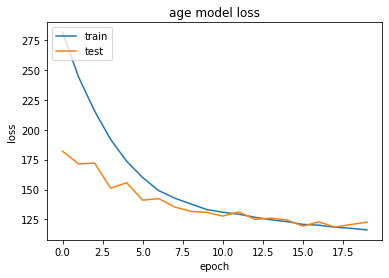

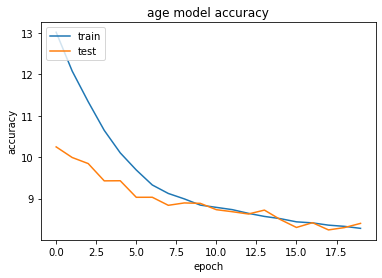

<Figure size 432x288 with 0 Axes>

In [156]:
#Plot age history
plt.plot(history.history['age_loss'])
plt.plot(history.history['val_age_loss'])
plt.title('age model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('age_loss.png')
plt.clf()

plt.plot(history.history['age_mae'])
plt.plot(history.history['val_age_mae'])
plt.title('age model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('age_mae.png')
plt.clf()

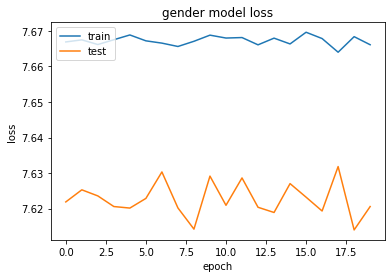

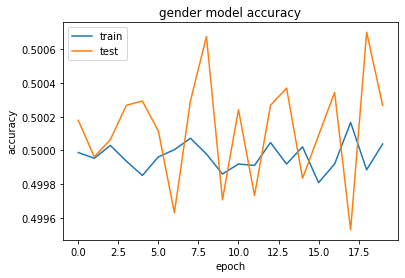

<Figure size 432x288 with 0 Axes>

In [158]:
#Plot gender history

plt.plot(history.history['gender_loss'])
plt.plot(history.history['val_gender_loss'])
plt.title('gender model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('gender_loss.png')
plt.clf()

plt.plot(history.history['gender_accuracy'])
plt.plot(history.history['val_gender_accuracy'])
plt.title('gender model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('gender_accuracy.png')
plt.clf()


In [32]:
#Evaluate
#model.evaluate_generator(generator=valid_generator,steps=STEP_SIZE_TEST)

In [ ]:

#Predict
test_generator.reset() #reset the test_generator before whenever you call the predict_generator
#pred_age,pred_gender=model.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)
predictions=model.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)
#
print(predictions)
#filenames=test_generator.filenames
#results=pd.DataFrame({"Filename":filenames,"Age Predictions":pred_age, "Gender Predictions":pred_gender})
#results.to_csv("cnn_results.csv",index=False)


In [163]:
print(testdf.age, pred_age)
print(testdf.gender)
print(pred_gender)
#predictions = pd.DataFrame(pred, columns=testdf.columns)
#predictions.head()

0        29
1        30
2        21
3        18
4        38
         ..
52561    22
52562    58
52563    32
52564    37
52565    33
Name: age, Length: 52566, dtype: int64 [[39.658257]
 [30.787624]
 [31.317913]
 ...
 [42.19061 ]
 [31.350756]
 [38.62463 ]]
0        0
1        1
2        1
3        0
4        1
        ..
52561    0
52562    1
52563    1
52564    0
52565    0
Name: gender, Length: 52566, dtype: object
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [167]:
#train and validation data generators

img_dim=128

datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

train_generator=datagen.flow_from_dataframe(dataframe=traindf,
directory=None,
x_col='full_path',
y_col=['gender','age'],
subset="training",
#try a smaller batch size                                            
batch_size=32,
seed=42,
shuffle=True,
class_mode='multi_output', 
target_size=(img_dim,img_dim))

valid_generator=datagen.flow_from_dataframe(
dataframe=traindf,
directory=None,
x_col='full_path',
y_col=['gender','age'],
subset="validation",
batch_size=32, #***Set this to some number that divides your total number of images in your test set exactly
seed=42,
shuffle=True,
class_mode='multi_output',
target_size=(img_dim,img_dim))

Found 117689 validated image filenames.
Found 39229 validated image filenames.


In [168]:
model = Model(inputs=inputs, outputs=[gender_model,age_model])
model.compile(optimizer = tf.keras.optimizers.Adam(0.002), 
              loss ={'gender':'binary_crossentropy','age':'mse'},metrics={"gender":"accuracy",'age':'mae'})
model.summary()

Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_162 (Conv2D)             (None, 64, 64, 128)  3584        input_29[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_31 (MaxPooling2D) (None, 31, 31, 128)  0           conv2d_162[0][0]                 
__________________________________________________________________________________________________
batch_normalization_134 (BatchN (None, 31, 31, 128)  512         max_pooling2d_31[0][0]           
___________________________________________________________________________________________

In [169]:
history = model.fit_generator(generator=train_generator,steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                    epochs=20,callbacks=callbacks)

Epoch 1/20
3677/3677 [==============================] - 2343s 637ms/step - loss: 135.2797 - gender_loss: 7.6677 - age_loss: 127.6122 - gender_accuracy: 0.4999 - age_mae: 8.5388 - val_loss: 81.0561 - val_gender_loss: 7.6242 - val_age_loss: 116.2685 - val_gender_accuracy: 0.5000 - val_age_mae: 8.2186
Epoch 2/20
3677/3677 [==============================] - 2394s 651ms/step - loss: 121.4563 - gender_loss: 7.6667 - age_loss: 113.7895 - gender_accuracy: 0.5000 - age_mae: 8.1887 - val_loss: 115.2484 - val_gender_loss: 7.6227 - val_age_loss: 116.2489 - val_gender_accuracy: 0.5001 - val_age_mae: 8.2553
Epoch 3/20
3677/3677 [==============================] - 2357s 641ms/step - loss: 120.9316 - gender_loss: 7.6669 - age_loss: 113.2648 - gender_accuracy: 0.5000 - age_mae: 8.1683 - val_loss: 101.8418 - val_gender_loss: 7.6236 - val_age_loss: 118.4923 - val_gender_accuracy: 0.5001 - val_age_mae: 8.1874
Epoch 4/20
3677/3677 [==============================] - 2365s 643ms/step - loss: 119.5331 - gender

KeyboardInterrupt: 

In [170]:
#With wrapper
def generator_wrapper(generator):
    for batch_x,batch_y in generator:
        yield (batch_x,[batch_y[:i] for i in range(2)]) #for the two outputs required: gender and age


In [ ]:
history = model.fit_generator(generator=generator_wrapper(train_generator),steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=generator_wrapper(valid_generator),
                    validation_steps=STEP_SIZE_VALID,
                    epochs=5,verbose=2)